### Kernel

In [ ]:
def objective(trial):
    # --- A. KERNEL PCA (vía Nystroem) ---
    # gamma: Controla qué tan "curvo" es el espacio.
    # Valores bajos (0.001) = casi lineal. Valores altos (0.5) = islas muy separadas.
    gamma = trial.suggest_float("gamma", 0.05, 0.3, log=True)
    
    # n_components_nys: Dimensiones del espacio curvo intermedio
    n_components_nys = trial.suggest_int("n_components_nys", 125, 250)
    
    # Transformación No Lineal
    feature_map = Nystroem(gamma=gamma, n_components=n_components_nys, kernel='rbf', random_state=42)
    X_transformed = feature_map.fit_transform(X_scaled)
    
    # --- B. PCA LINEAL (Limpieza) ---
    # Reducimos el ruido del espacio curvo antes de clusterizar
    n_comp_pca = trial.suggest_int("n_components_pca", 10, min(50, n_components_nys))
    pca = PCA(n_components=n_comp_pca, random_state=42)
    X_final = pca.fit_transform(X_transformed)
    
    # --- C. HDBSCAN ---
    min_cluster_size = trial.suggest_int("min_cluster_size", 40, 100)
    min_samples = trial.suggest_int("min_samples", 10, 40)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean', 
        cluster_selection_method='eom'
    ).fit(X_final)
    
    labels = clusterer.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Penalizaciones
    if n_clusters < 20: return -1.0
    if n_clusters > 60: return -1.0 # Demasiada fragmentación
    
    # Usamos Silhouette en una muestra para velocidad (10% de los datos o máx 3000)
    # DBCV suele fallar en espacios de Kernel muy distorsionados, Silhouette es más estable aquí.
    sample_size = min(3000, len(X_final))
    indices = np.random.choice(len(X_final), sample_size, replace=False)
    
    try:
        score = silhouette_score(X_final[indices], labels[indices])
    except:
        score = -1.0
        
    return score

# Ejecutar Optimización
print("\n--- Iniciando Búsqueda de Gamma Óptimo ---")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_params
print(f"\n✅ Mejor Score: {study.best_value:.4f}")
print("Mejores Parámetros:", best_params)

[I 2025-11-19 15:49:43,750] A new study created in memory with name: no-name-7b38edf2-0e91-4081-b69a-fbe845329afe



--- Iniciando Búsqueda de Gamma Óptimo ---


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-19 15:49:44,890] Trial 0 finished with value: 0.5130378387610155 and parameters: {'gamma': 0.12603398692296183, 'n_components_nys': 245, 'n_components_pca': 29, 'min_cluster_size': 77, 'min_samples': 29}. Best is trial 0 with value: 0.5130378387610155.
[I 2025-11-19 15:49:45,705] Trial 1 finished with value: 0.48154383262661155 and parameters: {'gamma': 0.09849278684031826, 'n_components_nys': 145, 'n_components_pca': 29, 'min_cluster_size': 83, 'min_samples': 12}. Best is trial 0 with value: 0.5130378387610155.
[I 2025-11-19 15:49:46,279] Trial 2 finished with value: 0.3623298651486154 and parameters: {'gamma': 0.1539774770442331, 'n_components_nys': 131, 'n_components_pca': 14, 'min_cluster_size': 58, 'min_samples': 37}. Best is trial 0 with value: 0.5130378387610155.
[I 2025-11-19 15:49:47,611] Trial 3 finished with value: 0.41344992923141466 and parameters: {'gamma': 0.2646004317390801, 'n_components_nys': 225, 'n_components_pca': 39, 'min_cluster_size': 45, 'min_samples

In [ ]:
# ==========================================
# 3. ENTRENAMIENTO DEL MODELO FINAL
# ==========================================
print("\n--- Entrenando Modelo Final ---")

# 1. Reconstruir la tubería con los ganadores
nystroem_final = Nystroem(
    gamma=best_params["gamma"], 
    n_components=best_params["n_components_nys"], 
    kernel='rbf', 
    random_state=42
)
X_nys_final = nystroem_final.fit_transform(X_scaled)

pca_final = PCA(n_components=best_params["n_components_pca"], random_state=42)
X_pca_final = pca_final.fit_transform(X_nys_final)

hdbscan_final = hdbscan.HDBSCAN(
    min_cluster_size=best_params["min_cluster_size"],
    min_samples=best_params["min_samples"],
    metric='euclidean',
    cluster_selection_method='leaf'
).fit(X_pca_final)

# 2. Asignar Clusters
df['cluster_kpca'] = -2 # Inicializar
df.loc[valid_indices, 'cluster_kpca'] = hdbscan_final.labels_

n_clusters = len(set(hdbscan_final.labels_)) - (1 if -1 in hdbscan_final.labels_ else 0)
print(f"Modelo Final Generado: {n_clusters} clusters encontrados.")


--- Entrenando Modelo Final ---
Modelo Final Generado: 30 clusters encontrados.


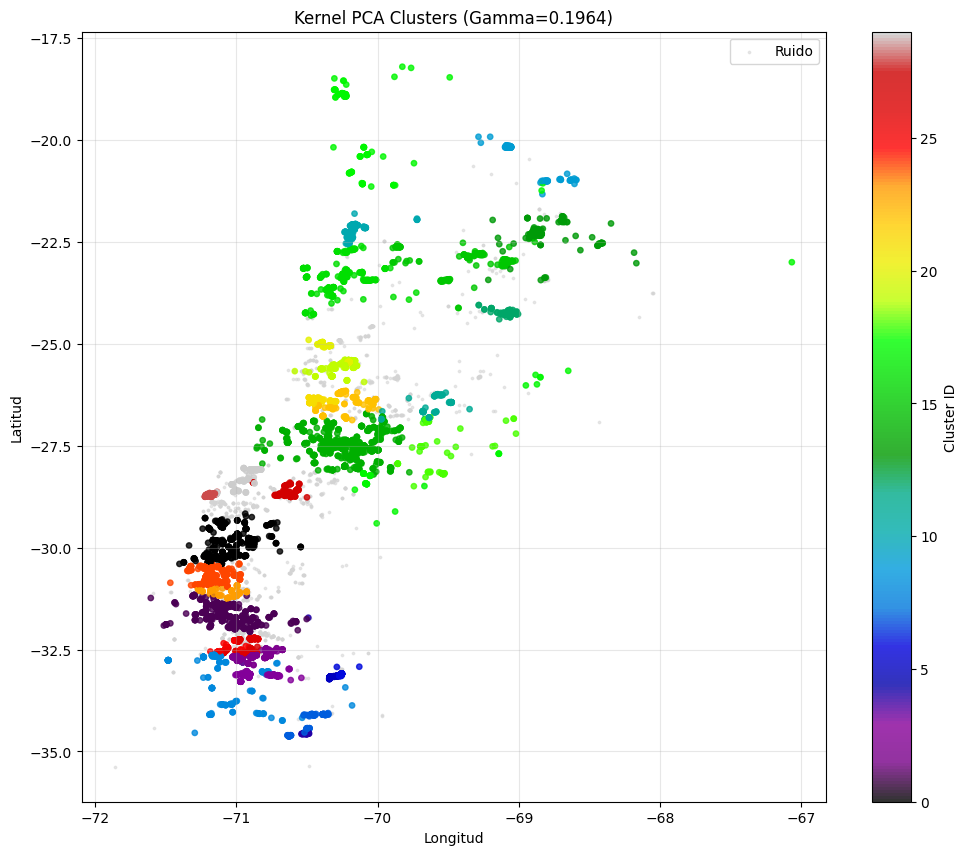

In [ ]:

# ==========================================
# 4. VISUALIZACIÓN
# ==========================================
plot_data = df[df['cluster_kpca'] != -2]

plt.figure(figsize=(12, 10))
# Ruido
noise = plot_data[plot_data['cluster_kpca'] == -1]
plt.scatter(noise['Longitud'], noise['Latitud'], c='lightgray', s=3, alpha=0.5, label='Ruido')

# Clusters
clustered = plot_data[plot_data['cluster_kpca'] != -1]
scatter = plt.scatter(clustered['Longitud'], clustered['Latitud'], 
                      c=clustered['cluster_kpca'], cmap='nipy_spectral', s=15, alpha=0.8)

plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Kernel PCA Clusters (Gamma={best_params["gamma"]:.4f})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import plotly.express as px

# Ensure the column is string so it plots as discrete colors, not a gradient
df['Cluster_Label'] = df['cluster_kpca'].astype(str)

fig = px.scatter_mapbox(
    df[df['cluster_kpca'] != -1], # We can exclude noise to make it cleaner
    lat="Latitud",
    lon="Longitud",
    color="Cluster_Label",
    hover_name="cluster_kpca",
    # hover_data=['NombreFaena', 'RecursoPrimarioInstalacion'], # Add this if those cols exist
    color_discrete_sequence=px.colors.qualitative.Dark24,
    zoom=4,
    height=800,
    title="Mapa Interactivo de Clusters Mineros (Chile)"
)

# Add Map Style
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()

C:\Users\artur\AppData\Local\Temp\ipykernel_13300\1956881932.py:6: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd

# --- CONFIGURACIÓN ---
# Ajusta este umbral. 
# 0.1 grados lat/lon son aprox. 11 km. 
# Si quieres unir faenas que disten hasta 20km, usa ~0.2
MERGE_THRESHOLD = 0.6

# Nombre de la columna que tiene los clusters actuales (del paso anterior)
col_origen = 'cluster_kpca'  # O 'cluster' si usaste el básico
col_destino = 'cluster_merged'

print(f"--- Iniciando fusión de clusters vecinos (Umbral: {MERGE_THRESHOLD}) ---")

# 1. Obtener etiquetas únicas (ignorando ruido -1 y nulos -2)
unique_labels = set(df[col_origen]) - {-1, -2}
centroids = []
label_map = []

# 2. Calcular el centroide (punto medio) de cada cluster existente
for label in unique_labels:
    # Filtramos las coordenadas de las minas de este cluster
    points = df[df[col_origen] == label][['Latitud', 'Longitud']].values
    centroid = points.mean(axis=0)
    centroids.append(centroid)
    label_map.append(label)

# 3. Aplicar el algoritmo de unión
if centroids:
    centroids = np.array(centroids)
    
    # AgglomerativeClustering con linkage='complete' asegura que 
    # todos los miembros del nuevo grupo estén dentro del umbral.
    agg = AgglomerativeClustering(
        n_clusters=None, 
        metric='euclidean', 
        linkage='complete', 
        distance_threshold=MERGE_THRESHOLD
    )
    
    # Esto nos da nuevas etiquetas simplificadas (0, 1, 2...)
    merged_labels = agg.fit_predict(centroids)
    
    # 4. Mapear las etiquetas viejas a las nuevas
    # Creamos un diccionario: {Cluster_Viejo -> Cluster_Nuevo}
    merge_dict = {}
    for old_lbl, new_lbl in zip(label_map, merged_labels):
        merge_dict[old_lbl] = new_lbl
        
    # Asegurar que el ruido (-1) y nulos (-2) se mantengan igual
    merge_dict[-1] = -1
    merge_dict[-2] = -2
    
    # 5. Aplicar al DataFrame
    df[col_destino] = df[col_origen].map(merge_dict)
    
    # Reporte de resultados
    n_before = len(unique_labels)
    n_after = len(set(merged_labels))
    print(f"✅ Fusión completada.")
    print(f"   Clusters Originales: {n_before}")
    print(f"   Clusters Fusionados: {n_after}")
    print(f"   Se redujeron {n_before - n_after} clusters redundantes.")
    
else:
    print("⚠️ No se encontraron clusters válidos para fusionar.")

--- Iniciando fusión de clusters vecinos (Umbral: 0.6) ---
✅ Fusión completada.
   Clusters Originales: 30
   Clusters Fusionados: 19
   Se redujeron 11 clusters redundantes.


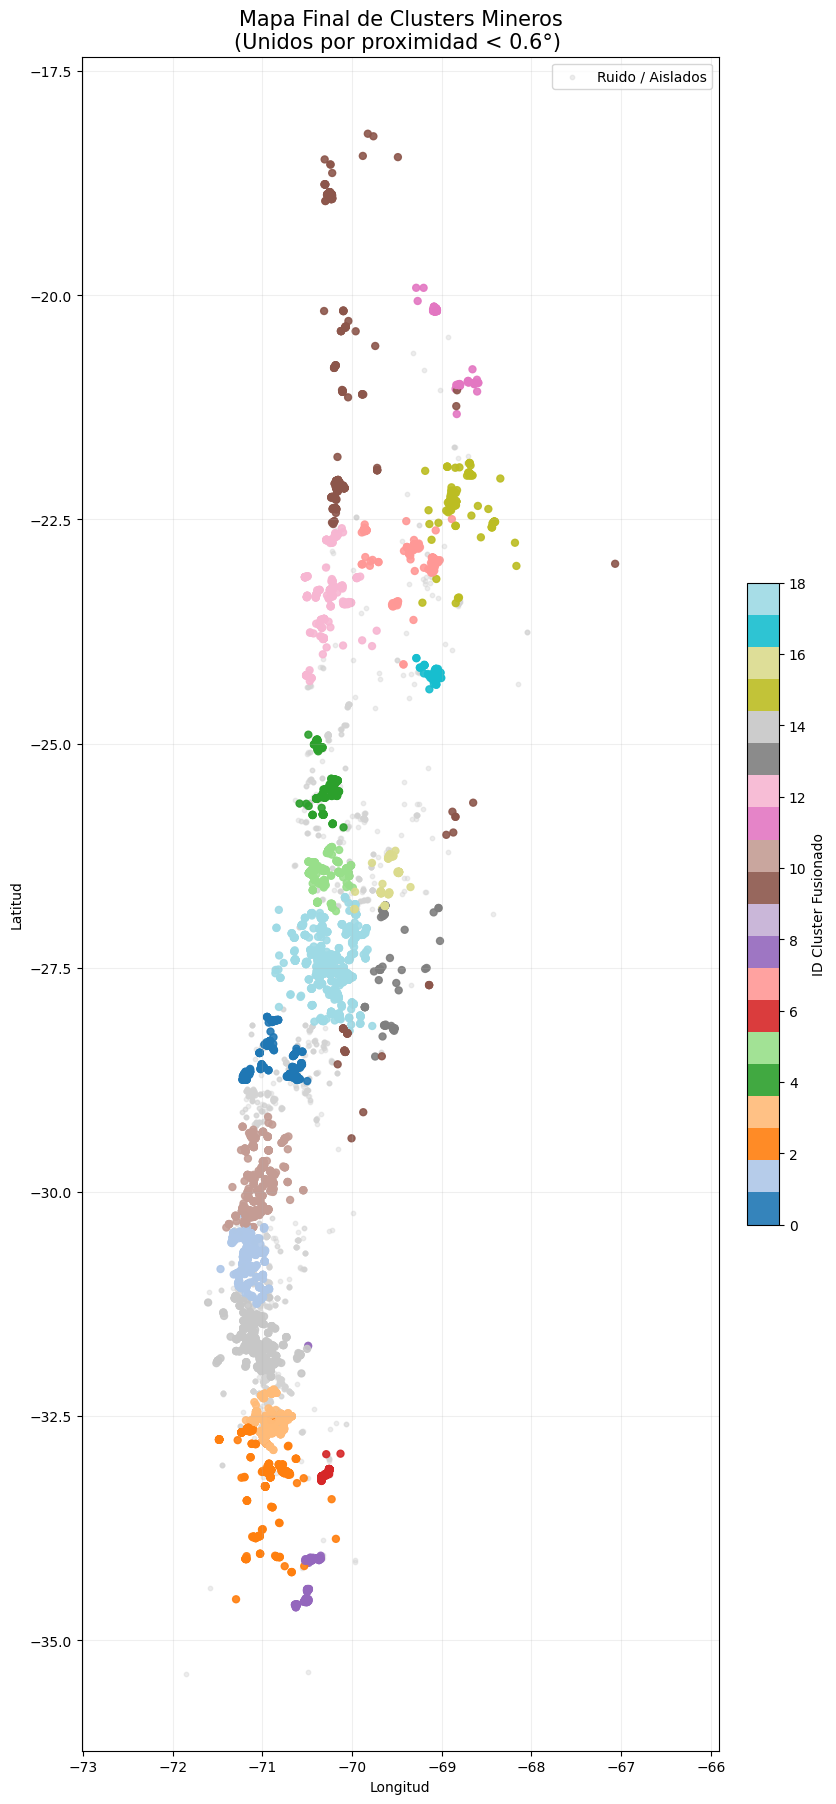

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 22)) # Figura alta para la forma de Chile

# 1. Graficar el Ruido (Puntos grises de fondo)
mask_noise = df['cluster_merged'] == -1
plt.scatter(df[mask_noise]['Longitud'], df[mask_noise]['Latitud'], 
            c='lightgray', s=10, alpha=0.4, label='Ruido / Aislados')

# 2. Graficar los Clusters Fusionados
mask_cluster = df['cluster_merged'] >= 0
clustered_data = df[mask_cluster]

# Usamos un colormap variado (tab20 o nipy_spectral) para distinguir zonas
scatter = plt.scatter(clustered_data['Longitud'], clustered_data['Latitud'], 
                      c=clustered_data['cluster_merged'], cmap='tab20', s=25, alpha=0.9)

plt.title(f'Mapa Final de Clusters Mineros\n(Unidos por proximidad < {MERGE_THRESHOLD}°) ', fontsize=15)
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Importante: 'equal' mantiene la proporción real del mapa para que Chile no se vea ancho
plt.axis('equal') 
plt.colorbar(scatter, label='ID Cluster Fusionado', fraction=0.046, pad=0.04)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

plt.show()